In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tcn import TCN
import warnings

warnings.filterwarnings('ignore')


In [31]:
# df['ML_Node'].value_counts()

In [32]:
selected_features = ['timestamp_seconds', # FixMe
                     'node_memory_Percpu_bytes', 
                     'node_context_switches_total', 
                     'surfsara_power_usage', 
                     'node_netstat_Tcp_InSegs', 
                     'node_netstat_Tcp_OutSegs', 
                     'node_network_transmit_packets_total-sum', 
                     'node_filesystem_size_bytes-sum', 
                     'node_filesystem_files-sum', 
                     'node_memory_MemFree_bytes', 
                     'node_netstat_Tcp_InErrs']
# FixMe

In [33]:
file_path = "myData2.parquet"
df = pd.read_parquet(file_path)


In [34]:
# Define time intervals
time_intervals = {'minute': '1T', 'hour': '1H', 'day': '1D'}

# Set sequence length
sequence_length = 30

# Number of time steps to predict into the future
prediction_steps_tcn = 7


In [35]:
# Function to prepare data for TCN
def prepare_tcn_data(data, time_interval):
    data.set_index('timestamp', inplace=True)
    data_resampled = data.resample(time_interval).sum()
    
    target_mean = data_resampled['target'].mean()
    target_std = data_resampled['target'].std()
    data_resampled['target'] = (data_resampled['target'] - target_mean) / target_std
    
    target_min = data_resampled['target'].min()
    target_max = data_resampled['target'].max()
    print("Minimum value of target variable:", target_min)
    print("Maximum value of target variable:", target_max)
    
    return data_resampled

# Function to create sequences for TCN
def create_tcn_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length].values
        target = data.iloc[i+sequence_length]['target']
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Function to make predictions on new data for TCN model
def predict_future_failures_tcn(model, input_data, sequence_length, prediction_steps):
    predictions = []

    for _ in range(prediction_steps):
        # Make a prediction for the next time step
        prediction = model.predict(input_data.reshape(1, sequence_length, input_data.shape[1]))
        predictions.append(prediction[0, 0])

        # Shift the input data by one time step and append the new prediction
        input_data = np.roll(input_data, shift=-1, axis=0)
        input_data[-1, -1] = prediction[0, 0]

    return predictions


# Day

In [36]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])



In [37]:
# Prepare data for TCN with day intervals
tcn_data_day = prepare_tcn_data(df_selected, time_intervals['day'])

# Create sequences and targets
sequences_day, targets_day = create_tcn_sequences(tcn_data_day, sequence_length)

# Split the data into training and testing sets
X_train_day, X_test_day, y_train_day, y_test_day = train_test_split(sequences_day, targets_day, test_size=0.3, random_state=1)

# Build the TCN model
tcn_model_day = Sequential([
    TCN(input_shape=(sequence_length, X_train_day.shape[2])),
    Dense(1, activation='sigmoid')
])

# Compile the model
tcn_model_day.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
history_day = tcn_model_day.fit(X_train_day, y_train_day, epochs=20, batch_size=32, validation_split=0.15)


Minimum value of target variable: -0.7362924419461765
Maximum value of target variable: 5.322951443655186
Epoch 1/20
2/2 [==============================] - 3s 467ms/step - loss: 0.8069 - mean_squared_error: 0.8069 - val_loss: 1.6482 - val_mean_squared_error: 1.6482
Epoch 2/20
2/2 [==============================] - 0s 86ms/step - loss: 0.8069 - mean_squared_error: 0.8069 - val_loss: 1.6482 - val_mean_squared_error: 1.6482
Epoch 3/20
2/2 [==============================] - 0s 85ms/step - loss: 0.8069 - mean_squared_error: 0.8069 - val_loss: 1.6482 - val_mean_squared_error: 1.6482
Epoch 4/20
2/2 [==============================] - 0s 82ms/step - loss: 0.8069 - mean_squared_error: 0.8069 - val_loss: 1.6482 - val_mean_squared_error: 1.6482
Epoch 5/20
2/2 [==============================] - 0s 84ms/step - loss: 0.8069 - mean_squared_error: 0.8069 - val_loss: 1.6482 - val_mean_squared_error: 1.6482
Epoch 6/20
2/2 [==============================] - 0s 83ms/step - loss: 0.8069 - mean_squared_error

## Performance_Day

In [38]:
# Evaluate the model using Mean Squred Error
mse_day = tcn_model_day.evaluate(X_test_day, y_test_day, verbose=0)[1]
print(f'Model Mean Squared Error: {mse_day:.4f}\n')


Model Mean Squared Error: 2.1163



In [39]:
# Evaluate model on test data
y_pred_day = tcn_model_day.predict(X_test_day)

# Calculate Root Mean Squared Error
rmse_day = mean_squared_error(y_test_day, y_pred_day, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse_day:.4f}\n')

# Calculate Mean Absolute Error
mae_day = mean_absolute_error(y_test_day, y_pred_day)
print(f'Mean Abosolute Error: {mae_day:.4f}\n')

# Calculate R-squared
r2_day = r2_score(y_test_day, y_pred_day)
print(f'R-squared (R2): {r2_day:.4f}\n')


1/1 [==============================] - 0s 349ms/step
Root Mean Squared Error (RMSE): 1.4547

Mean Abosolute Error: 1.0294

R-squared (R2): -0.0785



### Training and Validation Loss Plot

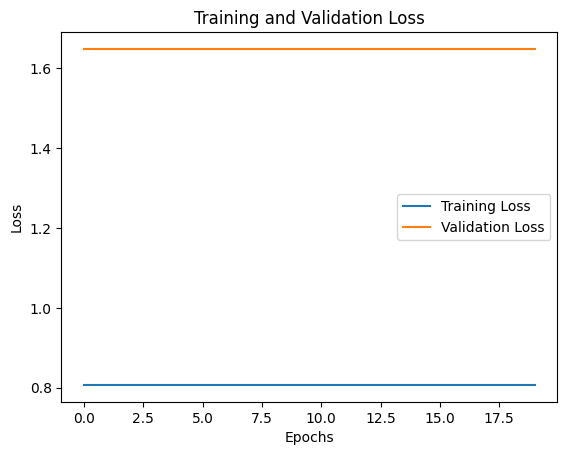

In [40]:
# Plot training and validation loss
plt.plot(history_day.history['loss'], label='Training Loss')
plt.plot(history_day.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Predicted Failures vs. True Failures Plot

In [41]:
target_min_day = -0.7362924419461765
target_max_day = 5.322951443655186

1/1 [==============================] - 0s 24ms/step
Predicted failures for the next 7 days:
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

Mean Squared Error for Predictions: 1.8063

Mean Absolute Error for Predictions: 1.1198


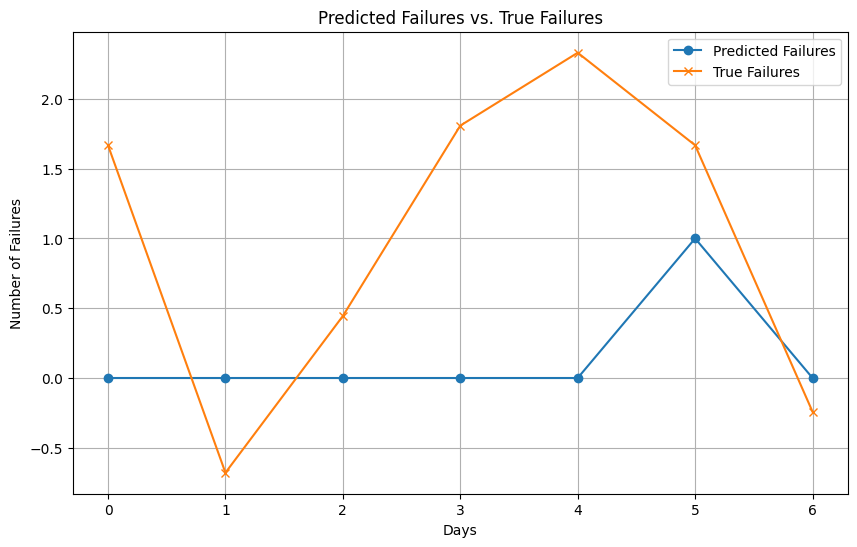

In [42]:
index_day = 0  # Can be any valid starting point

input_data_day = X_test_day[index_day]

# Make predictions
predicted_failures_day = predict_future_failures_tcn(tcn_model_day, input_data_day, sequence_length, prediction_steps_tcn)

# # Denormalize the predicted failures 
# predicted_failures_denormalized_day = np.array(predicted_failures_day) * (target_max_day - target_min_day) + target_min_day

# Get the true failures for the specified number of days
true_failures_day = y_test_day[index_day:index_day + prediction_steps_tcn]

# Print the predicted failures
print("Predicted failures for the next 7 days:")
print(predicted_failures_day)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures_day - true_failures_day)**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures_day - true_failures_day))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_day, label='Predicted Failures', marker='o')
plt.plot(true_failures_day, label='True Failures', marker='x')
plt.xlabel('Days')
plt.ylabel('Number of Failures')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.grid(True)
plt.show()


# Hour

In [43]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])



In [44]:
# Prepare data for TCN
tcn_data_hour = prepare_tcn_data(df_selected, time_intervals['hour'])

# Create sequences and targets
sequences_hour, targets_hour = create_tcn_sequences(tcn_data_hour, sequence_length)

# Split the data into training and testing sets
X_train_hour, X_test_hour, y_train_hour, y_test_hour = train_test_split(sequences_hour, targets_hour, test_size=0.3, random_state=1)

# Build the TCN model
tcn_model_hour = Sequential([
    TCN(input_shape=(sequence_length, X_train_hour.shape[2])),
    Dense(1, activation='sigmoid')
])

# Compile the model
tcn_model_hour.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
history_hour = tcn_model_hour.fit(X_train_hour, y_train_hour, epochs=20, batch_size=32, validation_split=0.15)


Minimum value of target variable: -0.44004356707964004
Maximum value of target variable: 22.33986610637043
Epoch 1/20
51/51 [==============================] - 5s 51ms/step - loss: 0.6561 - mean_squared_error: 0.6561 - val_loss: 0.5196 - val_mean_squared_error: 0.5196
Epoch 2/20
51/51 [==============================] - 2s 44ms/step - loss: 0.6549 - mean_squared_error: 0.6549 - val_loss: 0.5196 - val_mean_squared_error: 0.5196
Epoch 3/20
51/51 [==============================] - 2s 38ms/step - loss: 0.6549 - mean_squared_error: 0.6549 - val_loss: 0.5196 - val_mean_squared_error: 0.5196
Epoch 4/20
51/51 [==============================] - 2s 38ms/step - loss: 0.6549 - mean_squared_error: 0.6549 - val_loss: 0.5196 - val_mean_squared_error: 0.5196
Epoch 5/20
51/51 [==============================] - 2s 40ms/step - loss: 0.6549 - mean_squared_error: 0.6549 - val_loss: 0.5196 - val_mean_squared_error: 0.5196
Epoch 6/20
51/51 [==============================] - 2s 37ms/step - loss: 0.6549 - mean_s

## Performance_Hour

In [45]:
# Evaluate the model using Mean Squared Error
mse_hour = tcn_model_hour.evaluate(X_test_hour, y_test_hour, verbose=0)[1]
print(f'Model Mean Squared Error: {mse_hour:.4f}\n')


Model Mean Squared Error: 1.8850



In [46]:
# Evaluate model on test data
y_pred_hour = tcn_model_hour.predict(X_test_hour)

# Calculate Root Mean Squared Error
rmse_hour = mean_squared_error(y_test_hour, y_pred_hour, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse_hour:.4f}\n')

# Calculate Mean Absolute Error
mae_hour = mean_absolute_error(y_test_hour, y_pred_hour)
print(f'Mean Abosolute Error: {mae_hour:.4f}\n')

# Calculate R-squared
r2_hour = r2_score(y_test_hour, y_pred_hour)
print(f'R-squared (R2): {r2_hour:.4f}\n')


26/26 [==============================] - 1s 17ms/step
Root Mean Squared Error (RMSE): 1.3730

Mean Abosolute Error: 0.5628

R-squared (R2): -0.0015



### Training and Validation Loss Plot

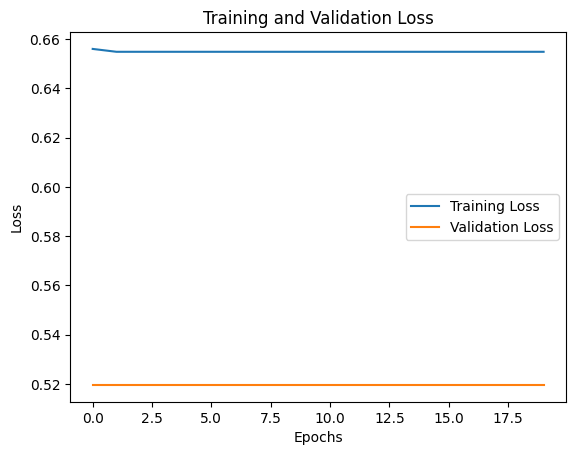

In [47]:
# Plot training and validation loss
plt.plot(history_hour.history['loss'], label='Training Loss')
plt.plot(history_hour.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Predicted Failures vs. True Failures Plot

In [48]:
target_min_hour =  0.44004356707964004
target_max_hour = 22.33986610637043

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step
Predicted failures for the next 7 hours:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Mean Squared Error for Predictions: 0.2871

Mean Absolute Error for Predictions: 0.4937


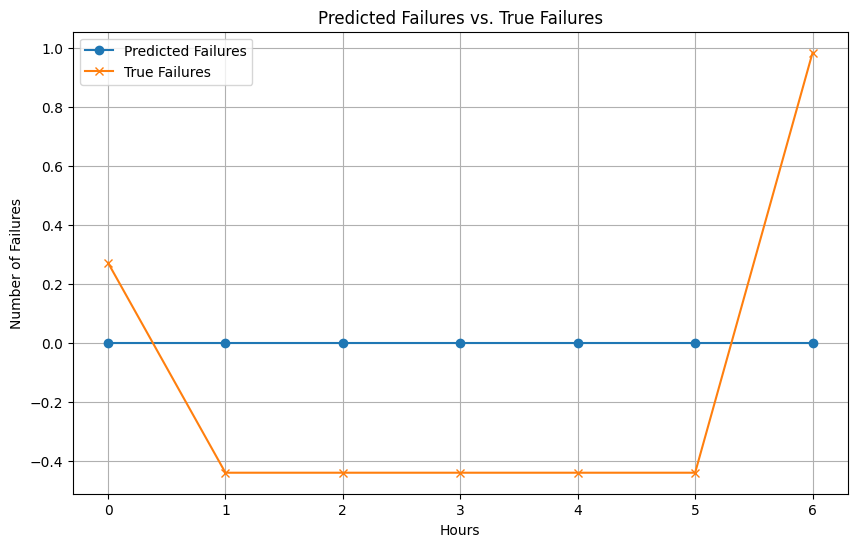

In [49]:
index_hour = 500  # Can be any valid starting point

input_data_hour = X_test_hour[index_hour]

# Make predictions
predicted_failures_hour = predict_future_failures_tcn(tcn_model_hour, input_data_hour, sequence_length, prediction_steps_tcn)

# # Denormalize the predicted failures 
# predicted_failures_denormalized_hour = np.array(predicted_failures_hour) * (target_max_hour - target_min_hour) + target_min_hour

# Get the true failures for the specified number of hours
true_failures_hour = y_test_hour[index_hour:index_hour + prediction_steps_tcn] 

# Print the predicted failures
print("Predicted failures for the next 7 hours:")
print(predicted_failures_hour)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures_hour - true_failures_hour)**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures_hour - true_failures_hour))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_hour, label='Predicted Failures', marker='o')
plt.plot(true_failures_hour, label='True Failures', marker='x')
plt.xlabel('Hours')
plt.ylabel('Number of Failures')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.grid(True)
plt.show()


# Minute

In [50]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])



In [51]:
# Prepare data for TCN
tcn_data_min = prepare_tcn_data(df_selected, time_intervals['minute'])

# Create sequences and targets
sequences_min, targets_min = create_tcn_sequences(tcn_data_min, sequence_length)

# Split the data into training and testing sets
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(sequences_min, targets_min, test_size=0.3, random_state=1)

# Build the TCN model
tcn_model_min = Sequential([
    TCN(input_shape=(sequence_length, X_train_min.shape[2])),
    Dense(1, activation='sigmoid')
])

# Compile the model
tcn_model_min.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
history_min = tcn_model_min.fit(X_train_min, y_train_min, epochs=5, batch_size=64, validation_split=0.15)


Minimum value of target variable: -0.43499466427008204
Maximum value of target variable: 22.077561101301857
Epoch 1/5
1539/1539 [==============================] - 99s 62ms/step - loss: 0.9970 - mean_squared_error: 0.9970 - val_loss: 0.9588 - val_mean_squared_error: 0.9588
Epoch 2/5
1539/1539 [==============================] - 93s 61ms/step - loss: 0.9966 - mean_squared_error: 0.9966 - val_loss: 0.9588 - val_mean_squared_error: 0.9588
Epoch 3/5
1539/1539 [==============================] - 94s 61ms/step - loss: 0.9966 - mean_squared_error: 0.9966 - val_loss: 0.9588 - val_mean_squared_error: 0.9588
Epoch 4/5
1539/1539 [==============================] - 94s 61ms/step - loss: 0.9966 - mean_squared_error: 0.9966 - val_loss: 0.9588 - val_mean_squared_error: 0.9588
Epoch 5/5
1539/1539 [==============================] - 94s 61ms/step - loss: 0.9966 - mean_squared_error: 0.9966 - val_loss: 0.9588 - val_mean_squared_error: 0.9588


## Performance_Minute

In [52]:
# Evaluate the model using Mean Squared Error
mse_min = tcn_model_min.evaluate(X_test_min, y_test_min, verbose=0)[1]
print(f'Mean Squared Error: {mse_min:.4f}\n')


Mean Squared Error: 1.0218



In [53]:
# Evaluate model on test data
y_pred_min = tcn_model_min.predict(X_test_min )

# Calculate Root Mean Squared Error
rmse_min = mean_squared_error(y_test_min, y_pred_min, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse_min:.4f}\n')

# Calculate Mean Absolute Error
mae_min = mean_absolute_error(y_test_min, y_pred_min)
print(f'Mean Abosolute Error: {mae_min:.4f}\n')

# Calculate R-squared
r2_min = r2_score(y_test_min, y_pred_min)
print(f'R-squared (R2): {r2_min:.4f}\n')


1270/1552 [=======================>......] - ETA: 4s

KeyboardInterrupt: 

### Training and Validation Loss Plot

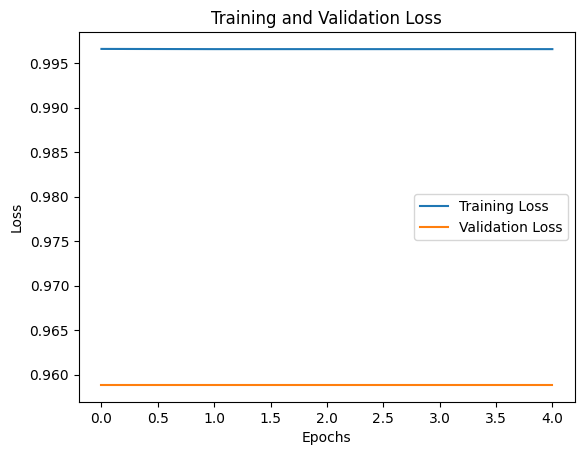

In [ ]:
# Plot training and validation loss
plt.plot(history_min.history['loss'], label='Training Loss')
plt.plot(history_min.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Predicted Failures vs. True Failures Plot

In [ ]:
target_min_min =  -0.43499466427008204
target_max_min = 22.077561101301857

1/1 [==============================] - 0s 22ms/step
Predicted failures for the next 7 minutes:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Mean Squared Error for Predictions: 0.3382

Mean Absolute Error for Predictions: 0.4933


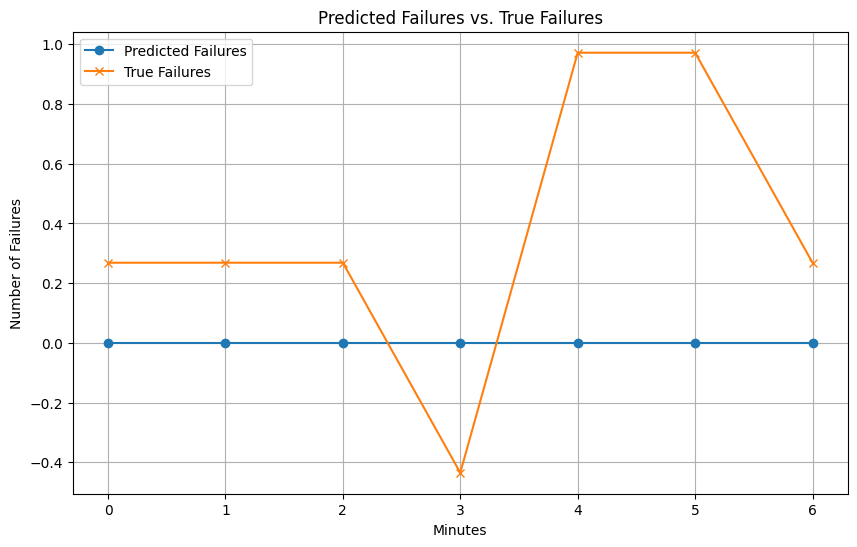

In [ ]:
index_min = 0  # Can be any valid starting point

input_data_min = X_test_min[index_min]

# Make predictions
predicted_failures_min = predict_future_failures_tcn(tcn_model_min, input_data_min, sequence_length, prediction_steps_tcn)

# # Denormalize the predicted failures 
# predicted_failures_denormalized_min = np.array(predicted_failures_min) * (target_max_min- target_min_min) + target_min_min

# Get the true failures for the specified number of minutes
true_failures_min = y_test_min[index_min:index_min + prediction_steps_tcn]

# Print the predicted failures
print("Predicted failures for the next 7 minutes:")
print(predicted_failures_min)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures_min - true_failures_min)**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures_min - true_failures_min))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_min, label='Predicted Failures', marker='o')
plt.plot(true_failures_min, label='True Failures', marker='x')
plt.xlabel('Minutes')
plt.ylabel('Number of Failures')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.grid(True)
plt.show()
